In [11]:
import os
from glob import glob

In [12]:
train_fns = glob(os.path.join('data', 'sentiment', 'train', '*', '*.txt'))
test_fns = glob(os.path.join('data', 'sentiment', 'test', '*', '*.txt'))

In [3]:
from tqdm import tqdm
max_length = 0


for fn in tqdm(train_fns):
    with open(fn) as f:
        lines = f.readlines()
        # lines is lies of len 1
        if len(lines) != 1: 
            print(lines)
            print('not of len 1')
            print(1/0)
        len_text = len(lines[0].split(' '))
        if len_text > max_length: max_length = len_text


print(max_length)
max_length = max_length * 2
print(f'max token length will be set to {max_length}')

  6%|▋         | 1581/25000 [00:04<01:13, 316.74it/s]


KeyboardInterrupt: 

In [18]:
from nlp import datasets
import importlib
importlib.reload(datasets)
from transformers import BertTokenizer
from torch.utils.data import DataLoader, random_split

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# for bert
max_length = 512

# create datasets
dataset = datasets.SentimentDataset(train_fns, tokenizer, max_length=max_length)
train_ratio = 0.9
eval_ratio = 1 - train_ratio
total_size = len(dataset)
train_size = int(total_size * train_ratio)
eval_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, eval_size])

test_dataset = datasets.SentimentDataset(test_fns, tokenizer, max_length=max_length)

# Create DataLoader
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f'Trainset has {len(train_dataset)} examples, testset has {len(test_dataset)}')


Trainset has 22500 examples, testset has 25000


In [14]:
import torch
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Training Loss: 0.7045
Epoch 1/3, Validation Loss: 0.6932
Epoch 2/3, Training Loss: 0.6958
Epoch 2/3, Validation Loss: 0.6931
Epoch 3/3, Training Loss: 0.6957
Epoch 3/3, Validation Loss: 0.6932


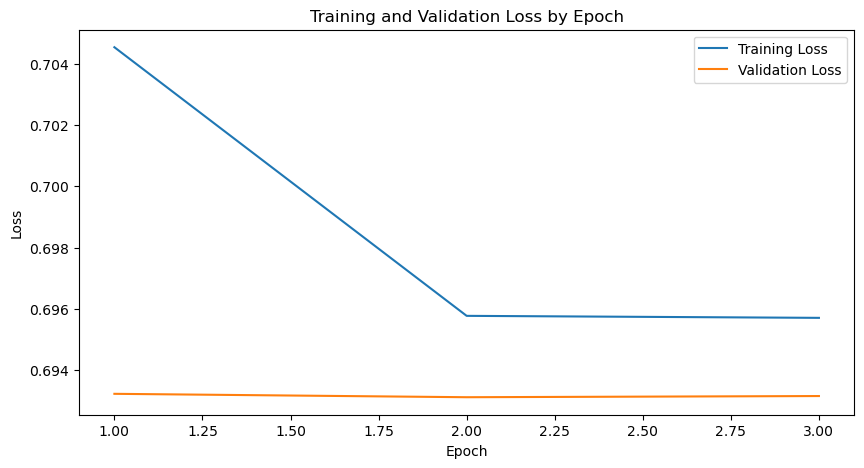

Test Accuracy: 0.5000


In [19]:
import matplotlib.pyplot as plt
import torch
from torch.optim import AdamW

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Move model to GPU if available
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)  # lr 2e-5 typical for BERT fine-tuning
criterion = torch.nn.CrossEntropyLoss()


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=3):

    val_losses = []
    train_losses = []

    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            # Get inputs from batch and move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: get predictions and compute loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Loss is already calculated internally for BertForSequenceClassification
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')


        # Validation loss
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}')


    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss by Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses



        
# Evaluate model on test set
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            # Compute accuracy
            total_correct += (predictions == labels).sum().item()
            total_examples += labels.size(0)

    accuracy = total_correct / total_examples
    print(f'Test Accuracy: {accuracy:.4f}')

# Fine-tune the model
print('starting training')
train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=3)

# Evaluate the fine-tuned model
print('pau training running evaluation')
evaluate_model(model, test_loader, device)

In [20]:
import joblib
joblib.dump(model, filename=os.path.join('first_task_model.pkl'))

['first_task_model.pkl']

In [21]:
# load model and compute performance
from sklearn.metrics import precision_score, recall_score, f1_score



model = joblib.load(filename=os.path.join('first_task_model.pkl'))



def evaluate_model(model, test_loader, device):
    model.eval()  
    total_correct = 0
    total_examples = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            # keep trak of predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_correct += (predictions == labels).sum().item()
            total_examples += labels.size(0)

    accuracy = total_correct / total_examples
    print(f'Test Accuracy: {accuracy:.4f}')

    # precision, recall, and F1 score
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return accuracy, precision, recall, f1


evaluate_model(model, test_loader, device)




Test Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1 Score: 0.3333


c:\Users\jnicolow\AppData\Local\anaconda3\envs\nlp-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.25, 0.5, 0.33333333333333326)